In [1]:
import pandas as pd
import glob, os, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy.io as spio
from scipy import signal
from collections import defaultdict
from datetime import datetime, timedelta
from obspy import read, Trace, UTCDateTime
import numpy.matlib
from matplotlib import cm
from scipy.io.wavfile import read as wavread
def to_pandas(data_set):
    datadict = {}
    for strg in data_set['detec']._fieldnames:
        elem = data_set['detec'].__dict__[strg]
        if isinstance(elem, spio.matlab.mat_struct):
            datadict[strg] = _todict(elem)
        else:
            datadict[strg] = elem
    if isinstance(elem, np.ndarray):
        return pd.DataFrame(datadict)
    else:
        return pd.DataFrame(datadict, index=[0])
def getinfo(place, year, index):
    df = pd.read_csv('../DataBase/Experiment_period.txt')
    df_ = df[df['region']==place][df['year']==year][df['index']==index]
    S = -1*df_['h_calib'].values[0]
    begintime = pd.to_datetime(df_['begin'].values[0])
    endtime = pd.to_datetime(df_['end'].values[-1])
    # month = str(begintime.month).zfill(2)
    return begintime, endtime, S

def calib(data, S):
    return data / ((10)**(S/20))
def readwav(path, S):
    rate, data = wavread(path)
    data = data.astype(np.float32, order='C') / 32768.0
    data = calib(data, S)
    
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    date = path.rsplit('.')[1]
    tr.stats.starttime = UTCDateTime(f'20{date[:12]}')
    tr.decimate(5, no_filter=True)
    # print(trslice.stats.statttime)
    tr = tr.filter('bandpass', freqmin=100, freqmax=2000, corners=4, zerophase=True)
    return tr

def ccf_coeff(tr1, tr2, freqmin=100, freqmax=2000): #500, 6000
    tr1_spec = np.fft.rfft(tr1.data)
    tr2_spec = np.fft.rfft(tr2.data)
    tr1_spec = signal.savgol_filter( abs(tr1_spec)/max(abs(tr1_spec)) , 20, 1, mode='nearest')
    tr2_spec = signal.savgol_filter( abs(tr2_spec)/max(abs(tr2_spec)) , 20, 1, mode='nearest')

    freq = np.linspace(0, tr1.stats.sampling_rate, tr1.stats.npts // 2 + 1)
    fidx = np.where((freq>=freqmin)&(freq<=freqmax))[0]
    fminidx = fidx[0]; fmaxidx = fidx[-1]
    coeff = np.corrcoef(tr1_spec[fminidx:fmaxidx], tr2_spec[fminidx:fmaxidx])
    
    # plt.figure(figsize=(6,4))
    # plt.subplot(211)
    # plt.plot(tr1.times(), tr1.data/max(tr1.data), 'k')
    # plt.plot(tr2.times(), tr2.data/max(tr2.data), 'r', alpha=0.5)
    # plt.xlim(tr2.times()[0], tr2.times()[-2])
    # plt.xlabel('Time (s)')
    # plt.subplot(212)
    # plt.plot(freq[fminidx:fmaxidx], tr1_spec[fminidx:fmaxidx], 'k')
    # plt.plot(freq[fminidx:fmaxidx], tr2_spec[fminidx:fmaxidx], 'r', alpha=0.5)
    # plt.xlim(freqmin, freqmax)
    # plt.xlabel('Frequency (Hz)')
    # plt.suptitle(f'coeff: {round(coeff[0][1],2)}')
    return coeff

In [2]:
path = '/Volumes/home/Research/Detect_fish/Taoyuan_csv'
wavdir = '/Volumes/Data/Soundscape/03_TaoYuan/2023/20230608-20230623/wav'
begin, end, S = getinfo('Taoyuan', 2023, 2)
examplepath  = '/Users/tong/Documents/09_IONTU/Results/sound/Taoyuan_fish_chorus_0616205203.wav'
tr_ex = read(examplepath)[0]

/var/folders/07/_m900g1931d1pc5dgv3v4qpw0000gn/T/ipykernel_2420/2703892922.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ = df[df['region']==place][df['year']==year][df['index']==index]


In [3]:
tr_ex

... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.300000Z | 96000.0 Hz, 28801 samples

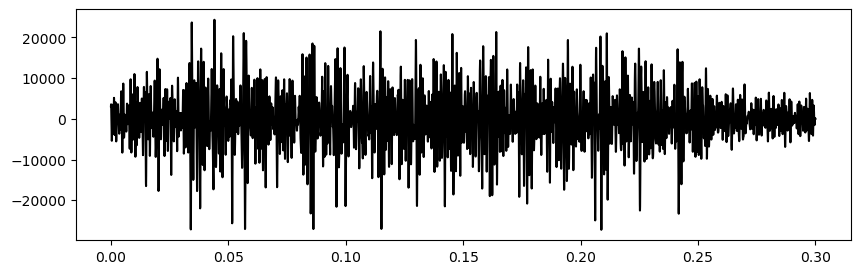

In [4]:
plt.figure(figsize=(10,3))
# tr_ex_slice = tr_ex.slice(starttime = tr_ex.stats.starttime+1.325, endtime = tr_ex.stats.starttime+1.475)
tr_ex_slice = tr_ex.decimate(factor=5, no_filter=True)
tr_ex_slice = tr_ex_slice.filter('bandpass', freqmin=100, freqmax=2000, corners=4, zerophase=True)
plt.plot(tr_ex_slice.times(), tr_ex_slice.data, 'k')

In [5]:
allSNR = pd.DataFrame()
for d in range(8,9):
    current = begin+timedelta(days=d)
    yy = str(current.year)[2:4]
    mm = str(current.month).zfill(2)
    dd = str(current.day).zfill(2)
    daydf = pd.DataFrame()
    
    for dirpath in glob.glob(f'{path}/230608-230623/{yy}{mm}{dd}/{yy}{mm}{dd}*'):
        hhdf = pd.DataFrame()
        
        for file in glob.glob(f'{dirpath}/*.mat'):
            mat = spio.loadmat(file, struct_as_record=False, squeeze_me=True)
            df = to_pandas(mat)
            _df = df[df['peaks']>=2]
            hhdf = pd.concat([hhdf, _df]) 
            coefflist = [] 
        if len(hhdf)>0:
            print(dirpath, len(hhdf))
            globwav = glob.glob(f'{wavdir}/*{dirpath.rsplit("/")[-1]}*')[0]
            # print(globwav)
            tr = readwav(globwav, S)
            print(tr)

            for i in range(len(hhdf)):
                begintmp = re.split('[(|)|,]',hhdf['time_min_date'].values[i]); endtmp = re.split('[(|)|,]',hhdf['time_max_date'].values[i])
                tr_begin = UTCDateTime(int(begintmp[1]),int(begintmp[2]),int(begintmp[3]),int(begintmp[4]),int(begintmp[5]),int(begintmp[6]),int(begintmp[7])-200)
                tr_end = UTCDateTime(int(endtmp[1]),int(endtmp[2]),int(endtmp[3]),int(endtmp[4]),int(endtmp[5]),int(endtmp[6]),int(endtmp[7])+200)
                tr_slice = tr.copy()
                tr_slice = tr_slice.slice(tr_begin, tr_end); del begintmp, endtmp
                if tr_slice.stats.npts > tr_ex_slice.stats.npts:
                    diff_pt = tr_slice.stats.npts - tr_ex_slice.stats.npts
                    tr_ex_slice_zero = tr_ex_slice.copy()
                    tr_ex_slice_zero.data = np.hstack((tr_ex_slice.data, np.zeros(diff_pt)))
                    # print(len(tr_ex_slice_zero.data), len(tr_slice.data))
                    coeff = ccf_coeff(tr_ex_slice_zero, tr_slice)
                elif tr_ex_slice.stats.npts > tr_slice.stats.npts:
                    diff_pt = tr_ex_slice.stats.npts - tr_slice.stats.npts
                    tr_slice_zero = tr_slice.copy()
                    tr_slice_zero.data = np.hstack((tr_slice_zero.data, np.zeros(diff_pt)))
                    # print(len(tr_slice_zero.data), len(tr_ex_slice.data))
                    coeff = ccf_coeff(tr_ex_slice, tr_slice_zero)
                coefflist.append(coeff[0][1])
                if coeff[0][1] >=0.80:
                    # print()
                    fig, ax = plt.subplots(2,1,figsize=(6,4))
                    plt.rc('font', family='Helvetica')
                    ax[0].plot(tr_slice.times()*1000, tr_slice.data, 'k')
                    ax[0].set_xlim(tr_slice.times()[0]*1000, tr_slice.times()[-1]*1000)
                    ax[0].set_title(f'{tr_slice.stats.starttime}    Coeff: {round(coeff[0][1], 2)}')
                    ax[0].set_xlabel('Time (ms)')
                    
                    
                    length = 96
                    # tr_slice_down = tr_slice.decimate(factor=10, no_filter=True)
                    f,t,P = signal.stft(tr_slice.data, fs= tr_slice.stats.sampling_rate, window='hann', 
                          nperseg=length, noverlap=int(0.95*length), nfft=2000, detrend='constant', boundary=None, padded=False)
                    data = 10*np.log10(np.abs(P)/np.power(1, 2)) #+ 176.2

                    axis=1
                    ambient = np.percentile(data, 10, axis=axis)
                    if axis==0:
                        input_data = np.subtract(data, np.matlib.repmat(ambient, data.shape[axis], 1))
                    elif axis==1:
                        input_data = np.subtract(data, np.matlib.repmat(ambient, data.shape[axis], 1).T)
                    im1 = ax[1].imshow(input_data, vmin=6, vmax=12,
                               origin='lower',  aspect='auto', cmap=cm.jet,
                               extent=[t[0]*1000, t[-1]*1000, f[0], f[-1]], interpolation='none')
                    ax[1].set_ylabel('Frequency (Hz)', fontsize=10)
                    ax[1].set_xlabel('Time (ms)' , fontsize=10)
                    ax[1].set_ylim(100, 2500)
                    ax[1].set_xlim(tr_slice.times()[0]*1000, tr_slice.times()[-1]*1000)
                    
                    hour = str(tr_slice.stats.starttime.hour).zfill(2)
                    minute = str(tr_slice.stats.starttime.minute).zfill(2)
                    second = str(tr_slice.stats.starttime.second).zfill(2)
                    plt.savefig(f'../Results/Detection_fishcall_grunt/fig/{yy}{mm}{dd}_{hour}{minute}{second}.png', bbox_inches='tight')
                    plt.close()
            hhdf['coeff'] = coefflist
        daydf = pd.concat([daydf, hhdf], ignore_index=True)
    daydf.to_csv(f'../Results/Detection_fishcall_grunt/csv/result_{yy}{mm}{dd}.csv', index=False)
    
                            ## cross correlation 

                

/Volumes/home/Research/Detect_fish/Taoyuan_csv/230608-230623/230616/23061600 704
... | 2023-06-16T00:00:02.000000Z - 2023-06-16T01:00:02.142135Z | 19200.0 Hz, 69122730 samples
/Volumes/home/Research/Detect_fish/Taoyuan_csv/230608-230623/230616/23061601 746
... | 2023-06-16T01:00:02.000000Z - 2023-06-16T02:00:02.162812Z | 19200.0 Hz, 69123127 samples
/Volumes/home/Research/Detect_fish/Taoyuan_csv/230608-230623/230616/23061602 638
... | 2023-06-16T02:00:02.000000Z - 2023-06-16T03:00:02.139948Z | 19200.0 Hz, 69122688 samples
/Volumes/home/Research/Detect_fish/Taoyuan_csv/230608-230623/230616/23061603 716
... | 2023-06-16T03:00:02.000000Z - 2023-06-16T04:00:02.169792Z | 19200.0 Hz, 69123261 samples
/Volumes/home/Research/Detect_fish/Taoyuan_csv/230608-230623/230616/23061604 669
... | 2023-06-16T04:00:02.000000Z - 2023-06-16T05:00:02.150469Z | 19200.0 Hz, 69122890 samples
/Volumes/home/Research/Detect_fish/Taoyuan_csv/230608-230623/230616/23061605 631
... | 2023-06-16T05:00:02.000000Z - 202

In [ ]:
# path = '/Volumes/home/Research/Detect_fish/Taoyuan_fig'
# for day in range(8,9):
#     dayy = str(day).zfill(2)
#     datepath = f'{path}/230608-230623/2306{dayy}'
#     cmd = 'mkdir %(datepath)s' %locals()
#     # os.system(cmd)
    
#     cmd = 'mv /Volumes/home/Research/Detect_fish/Taoyuan_fig/230608-230623/2306%(dayy)s?? %(datepath)s' %locals()
#     # os.system(cmd)    
    

In [ ]:
allSNR = pd.DataFrame()
daydf = pd.DataFrame()
for d in range(0,16):#16
    current = begin+timedelta(days=d)
    yy = str(current.year)[2:4]
    mm = str(current.month).zfill(2)
    dd = str(current.day).zfill(2)
    
    
    for dirpath in glob.glob(f'{path}/230608-230623/{yy}{mm}{dd}*'):
        print(dirpath)
        hhdf = pd.DataFrame()
        
        for file in glob.glob(f'{dirpath}/*/*.mat'):
            mat = spio.loadmat(file, struct_as_record=False, squeeze_me=True)
            df = to_pandas(mat)
            _df = df[df['peaks']>=5]
            hhdf = pd.concat([hhdf, df]) 
    daydf = pd.concat([daydf, hhdf], ignore_index=True)
    

In [ ]:
globwav = glob.glob(f'{wavdir}/*2304192035*')[0]
# print(globwav)
tr = readwav(globwav, S)

In [ ]:
tr_slice = tr.copy()
tr_begin = UTCDateTime(2023,4,19,20,35,28.9)
tr_end = UTCDateTime(2023,4,19,20,35,29.15)
tr_slice = tr_slice.slice(tr_begin, tr_end)

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6,4))
plt.rc('font', family='Helvetica')
ax[0].plot(tr_slice.times()*1000, tr_slice.data, 'k')
ax[0].set_xlim(tr_slice.times()[0]*1000, tr_slice.times()[-1]*1000)
ax[0].set_title(f'{tr_slice.stats.starttime}    Coeff: {round(coeff[0][1], 2)}')
ax[0].set_xlabel('Time (ms)')

tr_slice = tr_slice.filter('bandpass', freqmin=50, freqmax=5000, corners=4, zerophase=True)
length = 256/4
f, t, P = signal.stft(tr_slice.data, fs= tr_slice.stats.sampling_rate, window='hann', 
      nperseg=length, noverlap=int(0.9*length), nfft=5000, detrend='constant', boundary=None, padded=False)
data = 10*np.log10(np.abs(P)/np.power(1, 2)) #+ 176.2

axis=1
ambient = np.percentile(data,5, axis=axis)
if axis==0:
    input_data = np.subtract(data, np.matlib.repmat(ambient, data.shape[axis], 1))
elif axis==1:
    input_data = np.subtract(data, np.matlib.repmat(ambient, data.shape[axis], 1).T)
im1 = ax[1].imshow(input_data, vmin=6, vmax=20,
           origin='lower',  aspect='auto', cmap=cm.jet,
           extent=[t[0]*1000, t[-1]*1000, f[0], f[-1]], interpolation='none')
ax[1].set_ylabel('Frequency (Hz)', fontsize=10)
ax[1].set_xlabel('Time (ms)' , fontsize=10)
ax[1].set_ylim(100, 2000)
ax[1].set_xlim(tr_slice.times()[0]*1000, tr_slice.times()[-1]*1000)

In [ ]:
tr_slice_down